In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to your uploaded file
path = "D:\Private\Python\data\datasets\AEP_hourly.csv"
assert os.path.exists(path), f"File not found at {path}"

df_raw = pd.read_csv(
    path,
    parse_dates=["Datetime"],   
    infer_datetime_format=True
)

df_raw = df_raw.rename(columns=str.strip).sort_values("Datetime").set_index("Datetime")

print(df_raw.info())
print(df_raw.head(10))
print(df_raw.tail(10))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None
                      AEP_MW
Datetime                    
2004-10-01 01:00:00  12379.0
2004-10-01 02:00:00  11935.0
2004-10-01 03:00:00  11692.0
2004-10-01 04:00:00  11597.0
2004-10-01 05:00:00  11681.0
2004-10-01 06:00:00  12280.0
2004-10-01 07:00:00  13692.0
2004-10-01 08:00:00  14618.0
2004-10-01 09:00:00  14903.0
2004-10-01 10:00:00  15118.0
                      AEP_MW
Datetime                    
2018-08-02 15:00:00  18534.0
2018-08-02 16:00:00  18826.0
2018-08-02 17:00:00  18869.0
2018-08-02 18:00:00  18562.0
2018-08-02 19:00:00  18118.0
2018-08-02 20:00:00  17673.0
2018-08-02 21:00:00  17303.0
2018-08-02 22:00:00  17001.0
2018-08-02 23:00:00  15964.0
2018-08-03 00:00:00  14809.0


<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\1910368691.py:6: SyntaxWarning: invalid escape sequence '\P'
  path = "D:\Private\Python\data\datasets\AEP_hourly.csv"
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\1910368691.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_raw = pd.read_csv(


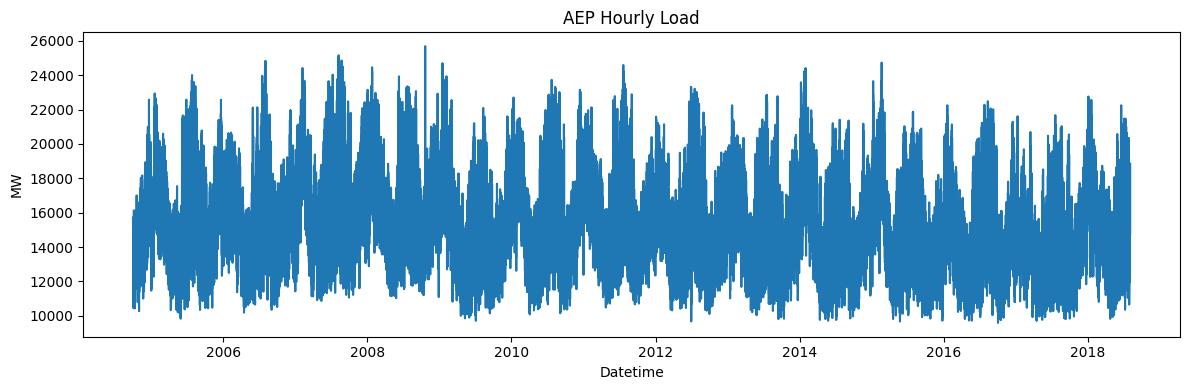

In [2]:

df_raw["AEP_MW"] = pd.to_numeric(df_raw.get("AEP_MW"), errors="coerce")

# 2) Line chart (full history)
plt.figure(figsize=(12, 4))
plt.plot(df_raw.index, df_raw["AEP_MW"])
plt.title("AEP Hourly Load")
plt.xlabel("Datetime")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

In [3]:
import os
import pandas as pd
import numpy as np

# --- Load ---
path = "D:\Private\Python\data\datasets\AEP_hourly.csv"
assert os.path.exists(path), f"File not found: {path}"
df = pd.read_csv(path)
df.columns = df.columns.str.strip()

print("Dtypes:\n", df.dtypes, "\n")

# --- 1) Uniques per column (including NaNs) ---
print("Unique counts (including NaN):")
print(df.nunique(dropna=False))

# --- 2) Inspect object (string) columns for weird entries ---
obj_cols = df.select_dtypes(include="object").columns.tolist()
if not obj_cols:
    print("\nNo object/string columns found.")
else:
    print("\nScanning object/string columns for oddities...")
    for col in obj_cols:
        s = df[col].astype(str)
        trimmed = s.str.strip()

        # Flags
        had_ws = s.ne(trimmed)  # leading/trailing whitespace
        nonprintable = trimmed.str.contains(r"[\x00-\x1F\x7F]", regex=True, na=False)
        suspicious_token = trimmed.str.lower().isin({"", "na", "nan", "none", "null", "-", "--", "n/a", "inf", "+inf", "-inf", "infinity"})
        weird_mask = had_ws | nonprintable | suspicious_token

        print(f"\n[{col}]")
        print(f"- unique values: {trimmed.nunique(dropna=False)}")
        print("- top 10 values:\n", trimmed.value_counts(dropna=False).head(10))

        n_weird = int(weird_mask.sum())
        print(f"- weird rows detected: {n_weird}")
        if n_weird:
            print(df.loc[weird_mask, [col]].head(10))

# --- 3) If a numeric column accidentally contains strings, catch them ---
# Common for AEP_hourly.csv: columns ['Datetime', 'AEP_MW'].
# We'll try to coerce AEP_MW and report any rows that fail.
if "AEP_MW" in df.columns:
    raw = df["AEP_MW"]

    # Check if it's already numeric; if not, try to coerce after removing commas
    as_str = raw.astype(str)
    # anything that's not digits, dot, minus, or whitespace will be flagged
    has_letters_or_symbols = as_str.str.contains(r"[A-Za-z]", na=False) | as_str.str.contains(r"[^\d\.\-\s,]", na=False)

    coerced = pd.to_numeric(as_str.str.replace(",", "", regex=False), errors="coerce")
    failed_coerce = coerced.isna() & raw.notna()

    weird_num_mask = has_letters_or_symbols | failed_coerce
    n_weird_num = int(weird_num_mask.sum())
    print(f"\n[AEP_MW] rows with non-numeric/weird representations: {n_weird_num}")
    if n_weird_num:
        print(df.loc[weird_num_mask, ["Datetime", "AEP_MW"]].head(20))

# --- 4) (Optional) Datetime parse check & duplicates ---
# If you want to ensure 'Datetime' parses and find dupes:
if "Datetime" in df.columns:
    dt_try = pd.to_datetime(df["Datetime"], errors="coerce", infer_datetime_format=True)
    n_bad_dt = int(dt_try.isna().sum())
    print(f"\n[Datetime] unparseable entries: {n_bad_dt}")
    if n_bad_dt:
        bad_idx = dt_try[dt_try.isna()].index
        print(df.loc[bad_idx, ["Datetime"]].head(10))

    # duplicate timestamps (after successful parse)
    good_dt = dt_try.dropna()
    n_dupes = int(good_dt.duplicated().sum())
    print(f"[Datetime] duplicate timestamps: {n_dupes}")


<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\686456966.py:6: SyntaxWarning: invalid escape sequence '\P'
  path = "D:\Private\Python\data\datasets\AEP_hourly.csv"


Dtypes:
 Datetime     object
AEP_MW      float64
dtype: object 

Unique counts (including NaN):
Datetime    121269
AEP_MW       12643
dtype: int64

Scanning object/string columns for oddities...

[Datetime]
- unique values: 121269
- top 10 values:
 Datetime
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2017-11-05 02:00:00    2
2018-01-02 17:00:00    1
2018-01-02 00:00:00    1
2018-01-01 10:00:00    1
2018-01-01 11:00:00    1
2018-01-01 12:00:00    1
2018-01-01 13:00:00    1
Name: count, dtype: int64
- weird rows detected: 0

[AEP_MW] rows with non-numeric/weird representations: 0

[Datetime] unparseable entries: 0
[Datetime] duplicate timestamps: 4


C:\Users\72526\AppData\Local\Temp\ipykernel_4908\686456966.py:65: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_try = pd.to_datetime(df["Datetime"], errors="coerce", infer_datetime_format=True)


        series   adf_stat       p_value  lags_used  n_obs   crit_1%   crit_5%  \
0        daily  -7.487516  4.597183e-11         30   5024 -3.431652 -2.862115   
1  daily_diff1 -16.222308  3.886557e-29         32   5021 -3.431653 -2.862116   

   crit_10%  
0 -2.567076  
1 -2.567077  


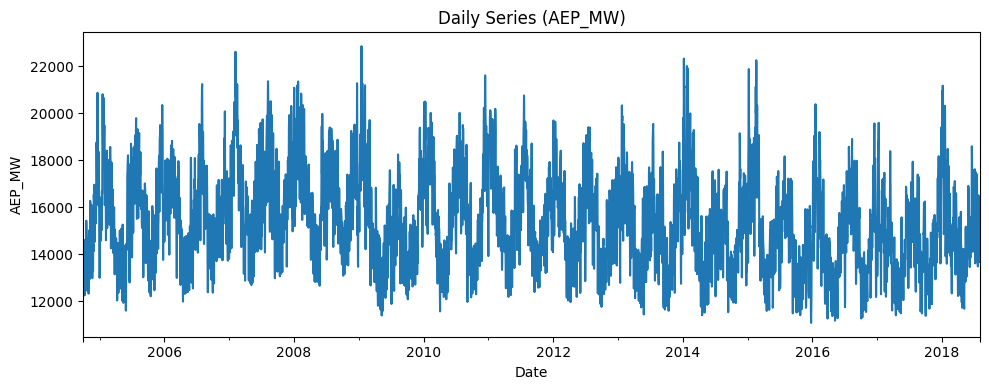

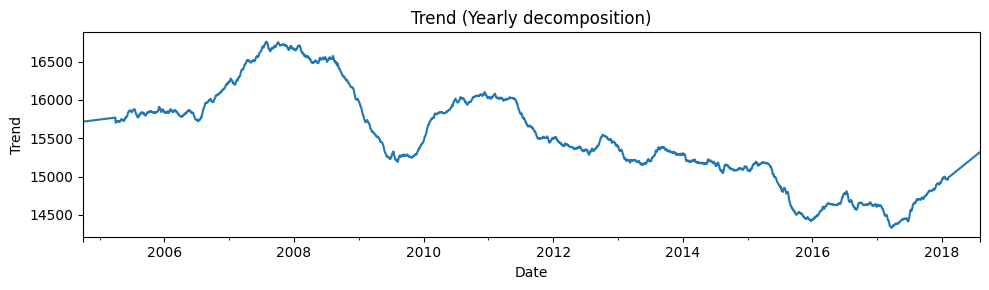

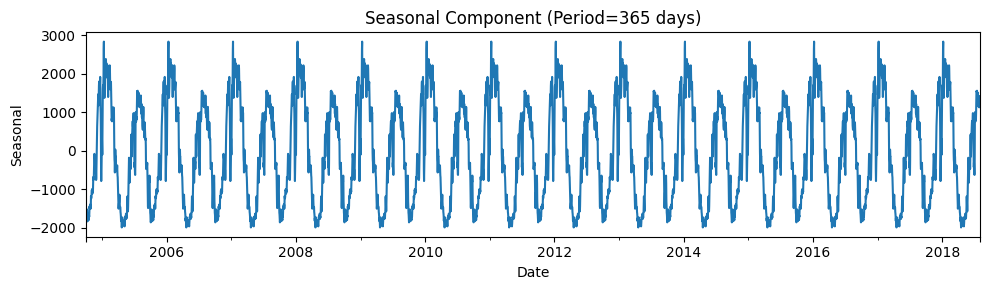

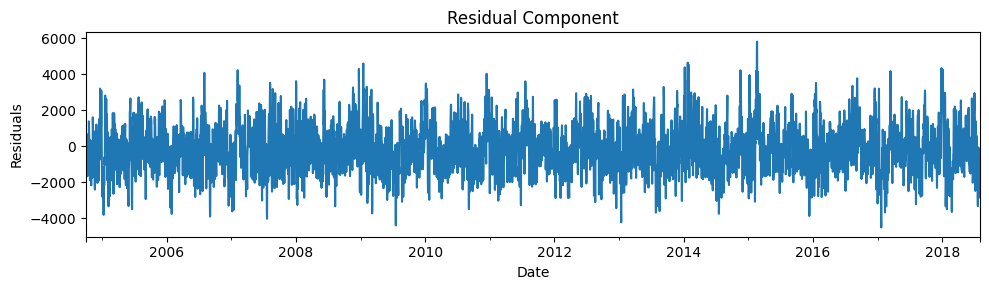

Detected value column: AEP_MW
ADF p-value (daily): 4.597183239476787e-11
ADF p-value (daily_diff1): 3.8865565512314384e-29
Approx. seasonal strength (yearly): 0.48056862090118013


In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

dt_col = "Datetime" if "Datetime" in df.columns else df.columns[0]
value_col = "AEP_MW" if "AEP_MW" in df.columns else df.columns[1]
df = df.copy()
df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce", utc=True)
df = df.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)
df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
df = df.dropna(subset=[value_col])

# Use daily average for tests to reduce noise and speed things up
y_daily = df[value_col].resample("D").mean().dropna()

# --- ADF on raw daily series ---
adf_raw = adfuller(y_daily, autolag="AIC")
adf_raw_stat, adf_raw_p, adf_raw_lags, adf_raw_n, adf_raw_crit, adf_raw_icbest = (
    adf_raw[0], adf_raw[1], adf_raw[2], adf_raw[3], adf_raw[4], adf_raw[5]
)

# --- ADF on first-differenced daily series (d=1) ---
y_diff1 = y_daily.diff().dropna()
adf_diff1 = adfuller(y_diff1, autolag="AIC")
adf_d1_stat, adf_d1_p, adf_d1_lags, adf_d1_n, adf_d1_crit, adf_d1_icbest = (
    adf_diff1[0], adf_diff1[1], adf_diff1[2], adf_diff1[3], adf_diff1[4], adf_diff1[5]
)

# Summarize ADF results in a small table
adf_table = pd.DataFrame(
    {
        "series": ["daily", "daily_diff1"],
        "adf_stat": [adf_raw_stat, adf_d1_stat],
        "p_value": [adf_raw_p, adf_d1_p],
        "lags_used": [adf_raw_lags, adf_d1_lags],
        "n_obs": [adf_raw_n, adf_d1_n],
        "crit_1%": [adf_raw_crit["1%"], adf_d1_crit["1%"]],
        "crit_5%": [adf_raw_crit["5%"], adf_d1_crit["5%"]],
        "crit_10%": [adf_raw_crit["10%"], adf_d1_crit["10%"]],
    }
)

print( adf_table)

# --- Seasonal decomposition (yearly seasonality on daily data: period=365)
# We'll do additive decomposition and plot each component in its own figure (no subplots).
decomp_year = seasonal_decompose(y_daily, model="additive", period=365, extrapolate_trend="freq")

# 1) Original series
plt.figure(figsize=(10, 4))
y_daily.plot()
plt.title("Daily Series (AEP_MW)")
plt.xlabel("Date")
plt.ylabel(value_col)
plt.tight_layout()
plt.show()

# 2) Trend
plt.figure(figsize=(10, 3))
decomp_year.trend.plot()
plt.title("Trend (Yearly decomposition)")
plt.xlabel("Date")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

# 3) Seasonal
plt.figure(figsize=(10, 3))
decomp_year.seasonal.plot()
plt.title("Seasonal Component (Period=365 days)")
plt.xlabel("Date")
plt.ylabel("Seasonal")
plt.tight_layout()
plt.show()

# 4) Residuals
plt.figure(figsize=(10, 3))
decomp_year.resid.plot()
plt.title("Residual Component")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Optional: compute a simple "seasonal strength" metric
# (Hyndman: Strength = max(0, 1 - Var(remainder)/Var(remainder + seasonal)))
valid = (~decomp_year.resid.isna()) & (~decomp_year.seasonal.isna())
resid = decomp_year.resid[valid]
seasonal = decomp_year.seasonal[valid]
seasonal_strength = max(0.0, 1.0 - (np.var(resid) / np.var(resid + seasonal)))

print("Detected value column:", value_col)
print("ADF p-value (daily):", adf_raw_p)
print("ADF p-value (daily_diff1):", adf_d1_p)
print("Approx. seasonal strength (yearly):", float(seasonal_strength))


Month-of-Year profile (daily averages)     month month_name          mean          std  count
0       1    January  17431.269009  1975.166014    434
1       2   February  17022.815084  1879.610053    395
2       3      March  15375.219808  1526.736327    434
3       4      April  13823.732591  1114.146156    420
4       5        May  14006.393817  1313.391112    434
5       6       June  15630.021825  1516.568795    420
6       7       July  16349.853303  1748.858440    434
7       8     August  16421.067529  1651.921103    406
8       9  September  14657.280556  1557.776994    390
9      10    October  13938.785727  1156.394168    434
10     11   November  14930.698319  1352.966033    420
11     12   December  16445.780012  1778.846306    434
Day-of-Week profile (daily averages)   weekday_name          mean          std  count
3       Monday  15810.973684  1840.615057    722
4      Tuesday  16057.519933  1829.488807    722
5    Wednesday  16013.589739  1841.945693    722
6     Thursda

<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\3906019639.py:5: SyntaxWarning: invalid escape sequence '\P'
  df_raw = pd.read_csv(Path("D:\Private\Python\data\datasets\AEP_hourly.csv"))


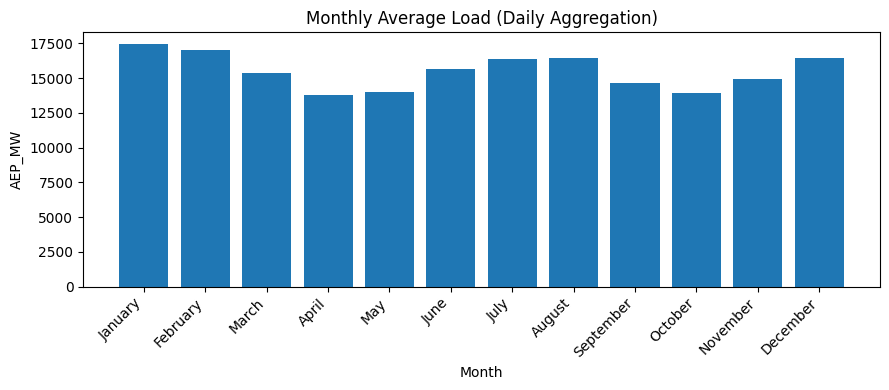

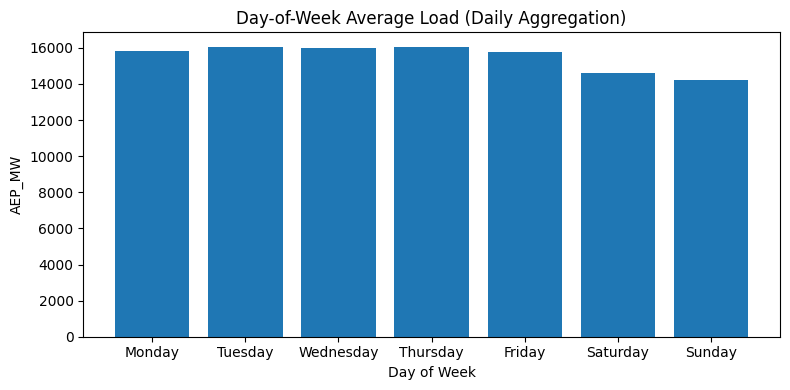

In [5]:

try:
    df
    value_col
except NameError:
    df_raw = pd.read_csv(Path("D:\Private\Python\data\datasets\AEP_hourly.csv"))
    dt_col = "Datetime" if "Datetime" in df_raw.columns else df_raw.columns[0]
    value_col = "AEP_MW" if "AEP_MW" in df_raw.columns else df_raw.columns[1]
    df = df_raw.copy()
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce", utc=True)
    df = df.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[value_col])

y_daily = df[value_col].resample("D").mean().dropna()
daily_df = y_daily.to_frame(name=value_col).copy()
daily_df["month"] = daily_df.index.month
daily_df["month_name"] = daily_df.index.month_name()
daily_df["weekday"] = daily_df.index.weekday
daily_df["weekday_name"] = daily_df.index.day_name()

# Month-of-year profile
mo_stats = (daily_df
            .groupby(["month", "month_name"], sort=True)[value_col]
            .agg(mean="mean", std="std", count="count")
            .reset_index()
            .sort_values("month"))
print("Month-of-Year profile (daily averages)", mo_stats)

# Day-of-week profile
dow_order = {name: i for i, name in enumerate(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])}
dow_stats = (daily_df
             .groupby(["weekday_name"], sort=False)[value_col]
             .agg(mean="mean", std="std", count="count")
             .reset_index())
dow_stats["order"] = dow_stats["weekday_name"].map(dow_order)
dow_stats = dow_stats.sort_values("order").drop(columns=["order"])
print("Day-of-Week profile (daily averages)", dow_stats)

# Plot: Month-of-year bar chart (means)
plt.figure(figsize=(9,4))
plt.bar(mo_stats["month_name"], mo_stats["mean"])
plt.title("Monthly Average Load (Daily Aggregation)")
plt.xlabel("Month")
plt.ylabel(value_col)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot: Day-of-week bar chart (means)
plt.figure(figsize=(8,4))
plt.bar(dow_stats["weekday_name"], dow_stats["mean"])
plt.title("Day-of-Week Average Load (Daily Aggregation)")
plt.xlabel("Day of Week")
plt.ylabel(value_col)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


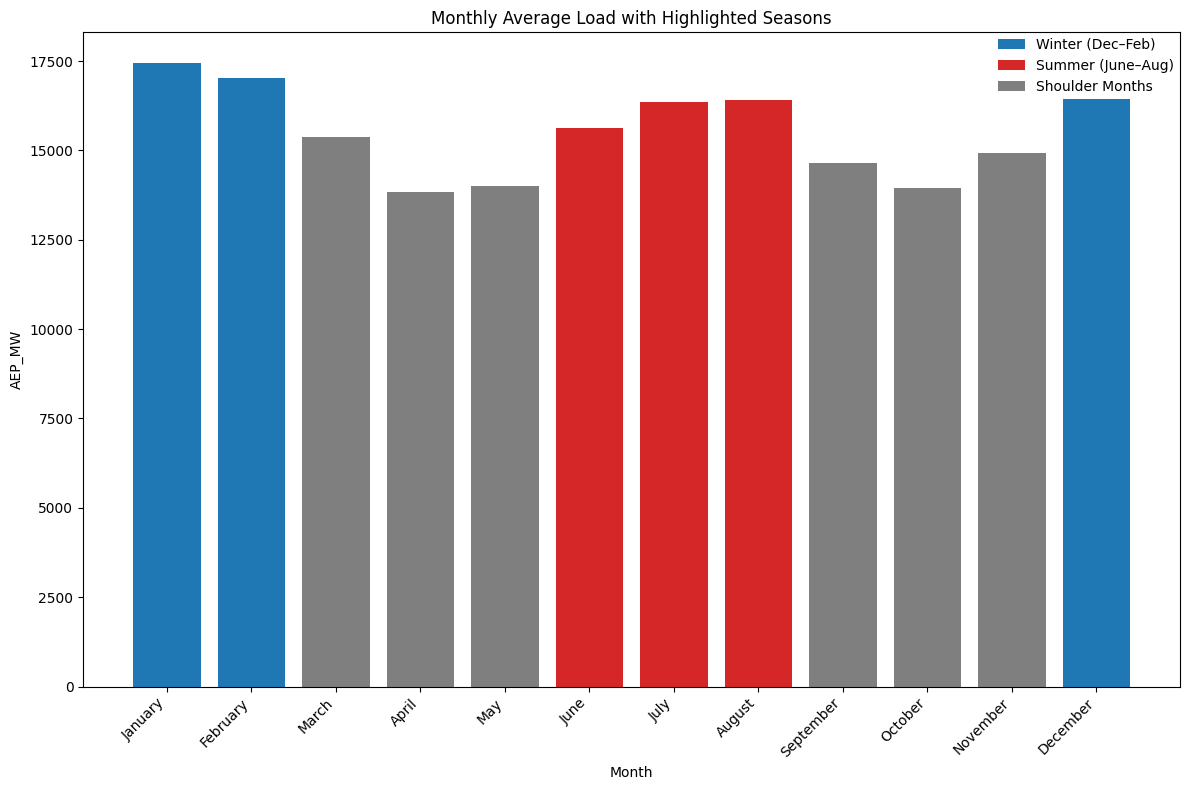

In [6]:


daily = df["AEP_MW"].resample("D").mean().dropna()
daily_df = daily.to_frame(name="AEP_MW")
daily_df["month"] = daily_df.index.month
daily_df["month_name"] = daily_df.index.month_name()
mo_stats = (daily_df
            .groupby(["month", "month_name"], sort=True)["AEP_MW"]
            .agg(mean="mean", std="std", count="count")
            .reset_index()
            .sort_values("month"))

months = mo_stats["month"].values
labels = mo_stats["month_name"].values
means = mo_stats["mean"].values

colors = []
for m in months:
    if m in (12, 1, 2):
        colors.append("#1f77b4")  # blue
    elif m in (6, 7, 8):
        colors.append("#d62728")  # red
    else:
        colors.append("#7f7f7f")  # gray

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, means, color=colors)
plt.title("Monthly Average Load with Highlighted Seasons")
plt.xlabel("Month")
plt.ylabel("AEP_MW")
plt.xticks(rotation=45, ha="right")

# Create a manual legend
from matplotlib.patches import Patch
legend_patches = [
    Patch(facecolor="#1f77b4", label="Winter (Dec–Feb)"),
    Patch(facecolor="#d62728", label="Summer (June–Aug)"),
    Patch(facecolor="#7f7f7f", label="Shoulder Months")
]
plt.legend(
    handles=legend_patches,
    loc="upper right",
    bbox_to_anchor=(1.0, 1.0),   # x=right edge, y=15% above the axes top
    frameon=False,
    borderaxespad=0.0
)
plt.tight_layout()
plt.show()


     index   winter_mean   summer_mean  winter_gt_summer  \
0   2005.0  16793.390278  16794.281250             False   
1   2006.0  17052.888426  16674.568841              True   
2   2007.0  17561.982870  17367.283967              True   
3   2008.0  18079.874542  17000.036232              True   
4   2009.0  17791.680093  15152.203351              True   
5   2010.0  17680.989352  16980.153533              True   
6   2011.0  17961.864614  16775.058424              True   
7   2012.0  16505.577381  16385.539402              True   
8   2013.0  16419.353261  15468.133152              True   
9   2014.0  17283.224537  15115.534420              True   
10  2015.0  17099.262500  15293.369565              True   
11  2016.0  15586.464286  15945.344656             False   
12  2017.0  15342.948148  15144.887681              True   
13  2018.0  16356.936574  15602.041016              True   

    diff_winter_minus_summer  
0                  -0.890972  
1                 378.319585  
2     

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\126838978.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("D:\Private\Python\data\datasets\AEP_hourly.csv")


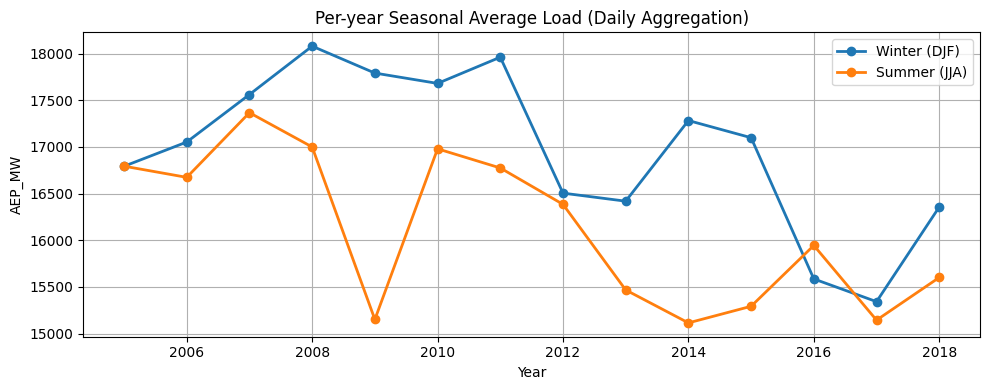

{'years_compared': 14, 'winter_higher_years': 12, 'summer_higher_years': 2, 'avg_winter': 16965.45977578322, 'avg_summer': 16121.316820733047, 'avg_diff_winter_minus_summer': 844.1429550501742}


In [7]:

# Ensure df and value_col exist; if not, reload quickly
df = pd.read_csv("D:\Private\Python\data\datasets\AEP_hourly.csv")
dt_col = "Datetime" if "Datetime" in df.columns else df.columns[0]
value_col = "AEP_MW" if "AEP_MW" in df.columns else df.columns[1]

df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce", utc=True)
df = df.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)
df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
df = df.dropna(subset=[value_col])

# Daily aggregation
y_daily = df[value_col].resample("D").mean().dropna()
daily = y_daily.to_frame(name=value_col)
daily["year"] = daily.index.year
daily["month"] = daily.index.month

# Build season labels using meteorological definitions
def season_label(ts):
    m = ts.month
    if m in (12, 1, 2):
        return "DJF"  # Winter
    elif m in (6, 7, 8):
        return "JJA"  # Summer
    else:
        return "Shoulder"

daily["season"] = daily.index.to_series().apply(season_label)

# Compute per-year seasonal means:
# For DJF winter, align by "winter year" = the year of Jan-Feb (Dec belongs to next year's winter)
winter_year = daily.index.to_series().apply(lambda d: d.year if d.month in (1,2) else (d.year + 1 if d.month == 12 else np.nan))
daily["winter_year"] = winter_year

# Summer aligns to calendar year
daily["summer_year"] = daily["year"]

# Aggregate
winter = (daily[daily["season"]=="DJF"]
          .dropna(subset=["winter_year"])
          .groupby("winter_year")[value_col]
          .mean()
          .rename("winter_mean"))

summer = (daily[daily["season"]=="JJA"]
          .groupby("summer_year")[value_col]
          .mean()
          .rename("summer_mean"))

season_compare = pd.concat([winter, summer], axis=1).dropna()
season_compare["winter_gt_summer"] = season_compare["winter_mean"] > season_compare["summer_mean"]
season_compare["diff_winter_minus_summer"] = season_compare["winter_mean"] - season_compare["summer_mean"]

print( season_compare.reset_index().rename(columns={"winter_year":"year"}))

# Plot the series over time for visual confirmation
plt.figure(figsize=(10,4))
plt.plot(season_compare.index, season_compare["winter_mean"], marker="o", label="Winter (DJF)", linewidth=2)
plt.plot(season_compare.index, season_compare["summer_mean"], marker="o", label="Summer (JJA)", linewidth=2)
plt.title("Per-year Seasonal Average Load (Daily Aggregation)")
plt.xlabel("Year")
plt.ylabel("AEP_MW")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary stats
summary = {
    "years_compared": int(season_compare.shape[0]),
    "winter_higher_years": int(season_compare["winter_gt_summer"].sum()),
    "summer_higher_years": int((~season_compare["winter_gt_summer"]).sum()),
    "avg_winter": float(season_compare["winter_mean"].mean()),
    "avg_summer": float(season_compare["summer_mean"].mean()),
    "avg_diff_winter_minus_summer": float(season_compare["diff_winter_minus_summer"].mean())
}
print(summary)


<>:14: SyntaxWarning: invalid escape sequence '\P'
<>:14: SyntaxWarning: invalid escape sequence '\P'
C:\Users\72526\AppData\Local\Temp\ipykernel_4908\4027623544.py:14: SyntaxWarning: invalid escape sequence '\P'
  df_raw = pd.read_csv(Path("D:\Private\Python\data\datasets\AEP_hourly.csv"))


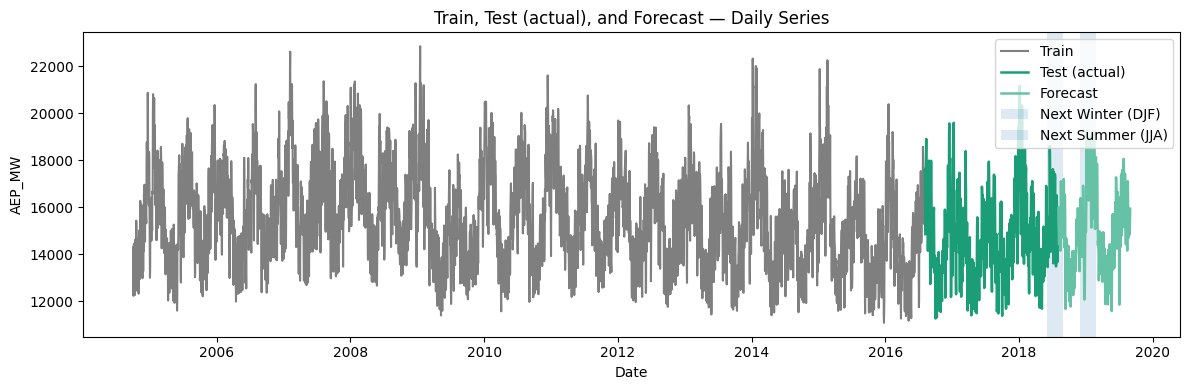

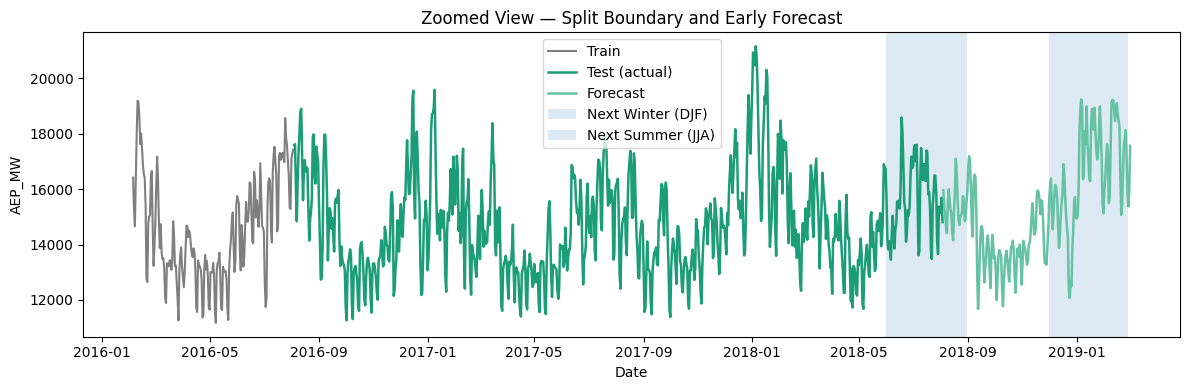

In [8]:
# Plot requested: show Train, Test (actual), and Forecast lines together,
# with the previous blue "Test" line changed to *green*.
# We'll render two charts (no subplots): (1) full history + forecast, (2) zoomed around split/forecast.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# --- Load & prepare daily series ---
df_raw = pd.read_csv(Path("D:\Private\Python\data\datasets\AEP_hourly.csv"))
dt_col = "Datetime" if "Datetime" in df_raw.columns else df_raw.columns[0]
val_col = "AEP_MW" if "AEP_MW" in df_raw.columns else df_raw.columns[1]
df_raw[dt_col] = pd.to_datetime(df_raw[dt_col], errors="coerce", utc=True)
df_raw[val_col] = pd.to_numeric(df_raw[val_col], errors="coerce")
df_raw = df_raw.dropna(subset=[dt_col, val_col]).sort_values(dt_col).set_index(dt_col)

y_daily = df_raw[val_col].resample("D").mean().dropna()
y_daily = y_daily.tz_convert("UTC") if y_daily.index.tz is not None else y_daily.tz_localize("UTC")

# --- Split: last 730 days = test ---
test_days = 730
split_date = y_daily.index[-test_days-1]
train = y_daily.loc[:split_date]
test  = y_daily.loc[split_date + pd.Timedelta(days=1):]

# --- Fit STL + ARIMA on TRAIN ---
stlf = STLForecast(train, ARIMA, period=365, model_kwargs={"order": (1,1,1)})
stlf_res = stlf.fit()

# --- Forecast horizon to cover next DJF & JJA after test ---
forecast_start = test.index[-1] + pd.Timedelta(days=1)
end_year = (forecast_start.year if forecast_start.month <= 8 else forecast_start.year + 1) + 1
forecast_end = pd.Timestamp(datetime(end_year, 8, 31)).tz_localize("UTC")
steps = (forecast_end - forecast_start).days + 1

fc = stlf_res.forecast(steps=steps)
fc.index = pd.date_range(start=forecast_start, periods=steps, freq="D", tz="UTC")

# --- Functions to get next DJF/JJA after a timestamp ---
def next_DJF_window(start_ts):
    y = start_ts.year
    dec1 = pd.Timestamp(datetime(y, 12, 1)).tz_localize("UTC")
    if start_ts > dec1: dec1 = pd.Timestamp(datetime(y+1, 12, 1)).tz_localize("UTC")
    feb_year = dec1.year + 1
    is_leap = (feb_year % 4 == 0) and ((feb_year % 100 != 0) or (feb_year % 400 == 0))
    feb_last = 29 if is_leap else 28
    feb_end = pd.Timestamp(datetime(feb_year, 2, feb_last)).tz_localize("UTC")
    return dec1, feb_end

def next_JJA_window(start_ts):
    y = start_ts.year
    jun1 = pd.Timestamp(datetime(y, 6, 1)).tz_localize("UTC")
    aug31 = pd.Timestamp(datetime(y, 8, 31)).tz_localize("UTC")
    if start_ts > aug31:
        jun1 = pd.Timestamp(datetime(y+1, 6, 1)).tz_localize("UTC")
        aug31 = pd.Timestamp(datetime(y+1, 8, 31)).tz_localize("UTC")
    elif start_ts > jun1:
        pass
    return jun1, aug31

djf_start, djf_end = next_DJF_window(test.index[-1] + pd.Timedelta(days=1))
jja_start, jja_end = next_JJA_window(test.index[-1] + pd.Timedelta(days=1))

# --- Colors (requested change: test line should be green) ---
c_train = "#7f7f7f"      # gray
c_test  = "#1b9e77"      # green (was blue)
c_fc    = "#66c2a4"      # lighter green for forecast
shade   = (0.15)         # alpha for seasonal shading

# --- Chart 1: Full history + forecast ---
plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Train", color=c_train, linewidth=1.5)
plt.plot(test.index, test.values, label="Test (actual)", color=c_test, linewidth=1.8)
plt.plot(fc.index, fc.values, label="Forecast", color=c_fc, linewidth=1.8)

plt.axvspan(djf_start, djf_end, alpha=shade, label="Next Winter (DJF)")
plt.axvspan(jja_start, jja_end, alpha=shade, label="Next Summer (JJA)")

plt.title("Train, Test (actual), and Forecast — Daily Series")
plt.xlabel("Date")
plt.ylabel(val_col)
plt.legend()
plt.tight_layout()
plt.show()

# --- Chart 2: Zoomed around split/forecast ---
zoom_start = split_date - pd.Timedelta(days=180)
zoom_end   = fc.index.min() + pd.Timedelta(days=210)

plt.figure(figsize=(12,4))
plt.plot(train.loc[zoom_start:split_date].index,
         train.loc[zoom_start:split_date].values,
         label="Train", color=c_train, linewidth=1.5)
plt.plot(test.index, test.values, label="Test (actual)", color=c_test, linewidth=1.8)
plt.plot(fc.loc[:zoom_end].index, fc.loc[:zoom_end].values, label="Forecast", color=c_fc, linewidth=1.8)

plt.axvspan(djf_start, djf_end, alpha=shade, label="Next Winter (DJF)")
plt.axvspan(jja_start, jja_end, alpha=shade, label="Next Summer (JJA)")

plt.title("Zoomed View — Split Boundary and Early Forecast")
plt.xlabel("Date")
plt.ylabel(val_col)
plt.legend()
plt.tight_layout()
plt.show()


Seasonal mean table (last few years):
          Winter_DJF    Summer_JJA
2014.0  17283.224537  15115.534420
2015.0  17099.262500  15293.369565
2016.0  15586.464286  15945.344656
2017.0  15342.948148  15144.887681
2018.0  16356.936574  15522.136433
2019.0  16582.572713  15645.387311


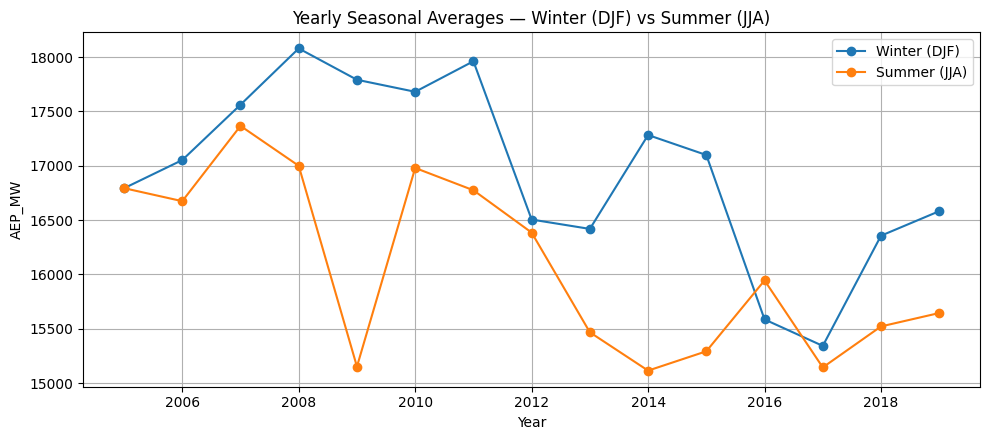

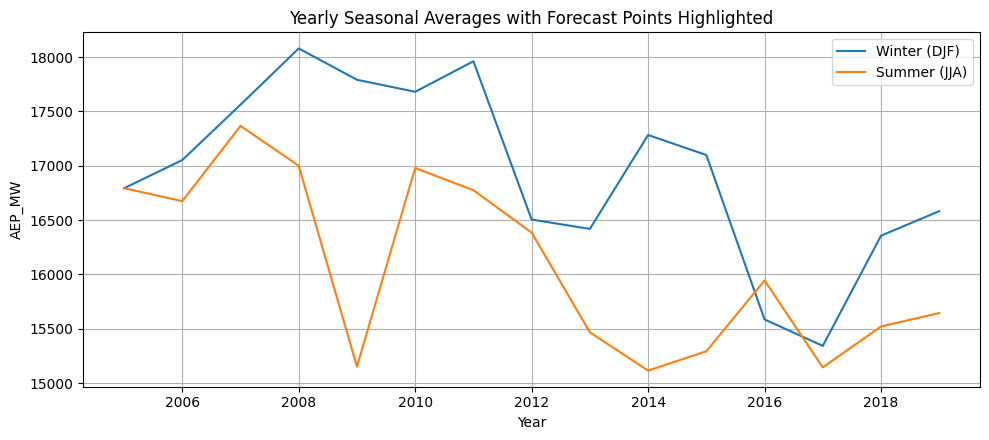

In [9]:

# === Continue from your code above ===
# Build a continuous daily series that includes history + forecast
daily_full = y_daily.copy()
fc_series = fc.copy()
# In case of any overlap, prefer actuals
daily_full = daily_full.combine_first(fc_series)

# Helper: compute per-year DJF (winter) and JJA (summer) means
df_season = daily_full.to_frame(name=val_col)
df_season["year"] = df_season.index.year
df_season["month"] = df_season.index.month

# Winter (DJF): assign a "winter_year" so Dec belongs to next year's winter
def winter_year(dt):
    m = dt.month
    y = dt.year
    return y if m in (1, 2) else (y + 1 if m == 12 else np.nan)

df_season["winter_year"] = df_season.index.to_series().apply(winter_year)
winter_means = (
    df_season[df_season["month"].isin([12, 1, 2])]
    .dropna(subset=["winter_year"])
    .groupby("winter_year")[val_col]
    .mean()
    .rename("Winter_DJF")
)

# Summer (JJA): simple calendar-year grouping
summer_means = (
    df_season[df_season["month"].isin([6, 7, 8])]
    .groupby("year")[val_col]
    .mean()
    .rename("Summer_JJA")
)

# Combine seasonal means into one DataFrame
seasonal_means = pd.concat(
    [
        winter_means.to_frame(),
        summer_means.to_frame(),
    ],
    axis=1
).sort_index()

# Optional: limit to years where we have at least 60 daily observations per season (avoid partial seasons)
# (You can comment this block out if you want to keep partial seasons.)
def count_days_in_season(series, months, assign_year=None):
    tmp = df_season[df_season["month"].isin(months)].copy()
    if assign_year == "winter":
        key = "winter_year"
    else:
        key = "year"
    return tmp.groupby(key)[val_col].count()

winter_counts = count_days_in_season(daily_full, [12,1,2], assign_year="winter")
summer_counts = count_days_in_season(daily_full, [6,7,8], assign_year=None)

valid_winter_years = winter_counts[winter_counts >= 60].index
valid_summer_years = summer_counts[summer_counts >= 60].index

seasonal_means = seasonal_means.loc[
    seasonal_means.index.intersection(valid_winter_years).union(
        seasonal_means.index.intersection(valid_summer_years)
    )
].sort_index()

# Identify which points are forecast (i.e., year >= 2019 for DJF and year >= 2020 for JJA in your setup)
seasonal_means["DJF_is_forecast"] = seasonal_means.index >= 2020   # DJF 2019–2020 labeled as 2020
seasonal_means["JJA_is_forecast"] = seasonal_means.index >= 2020   # JJA 2020

print("Seasonal mean table (last few years):")
print(seasonal_means.tail(6)[["Winter_DJF","Summer_JJA"]])

# --- Line chart: yearly Winter (DJF) and Summer (JJA) averages ---
plt.figure(figsize=(10,4.5))
seasonal_means["Winter_DJF"].plot(marker="o", label="Winter (DJF)")
seasonal_means["Summer_JJA"].plot(marker="o", label="Summer (JJA)")
plt.title("Yearly Seasonal Averages — Winter (DJF) vs Summer (JJA)")
plt.xlabel("Year")
plt.ylabel(val_col)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: emphasize the forecast points with larger markers/annotations ---
plt.figure(figsize=(10,4.5))
# Plot full lines
seasonal_means["Winter_DJF"].plot(label="Winter (DJF)")
seasonal_means["Summer_JJA"].plot(label="Summer (JJA)")

# Highlight forecast points (if present)
djf_fore = seasonal_means[seasonal_means["DJF_is_forecast"]]["Winter_DJF"]
jja_fore = seasonal_means[seasonal_means["JJA_is_forecast"]]["Summer_JJA"]
plt.plot(djf_fore.index, djf_fore.values, "o", markersize=8)
plt.plot(jja_fore.index, jja_fore.values, "o", markersize=8)

plt.title("Yearly Seasonal Averages with Forecast Points Highlighted")
plt.xlabel("Year")
plt.ylabel(val_col)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Seasonal mean table (last few years):
          Winter_DJF    Summer_JJA
2014.0  17283.224537  15115.534420
2015.0  17099.262500  15293.369565
2016.0  15586.464286  15945.344656
2017.0  15342.948148  15144.887681
2018.0  16356.936574  15522.136433
2019.0  16582.572713  15645.387311


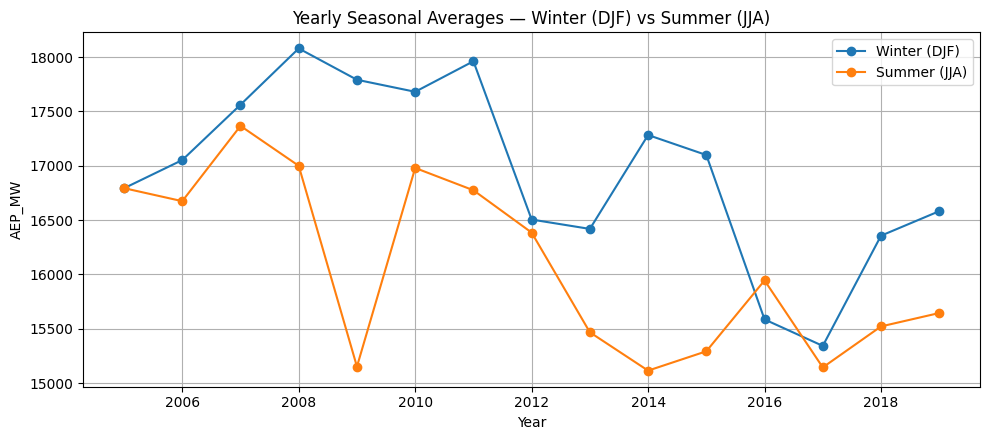

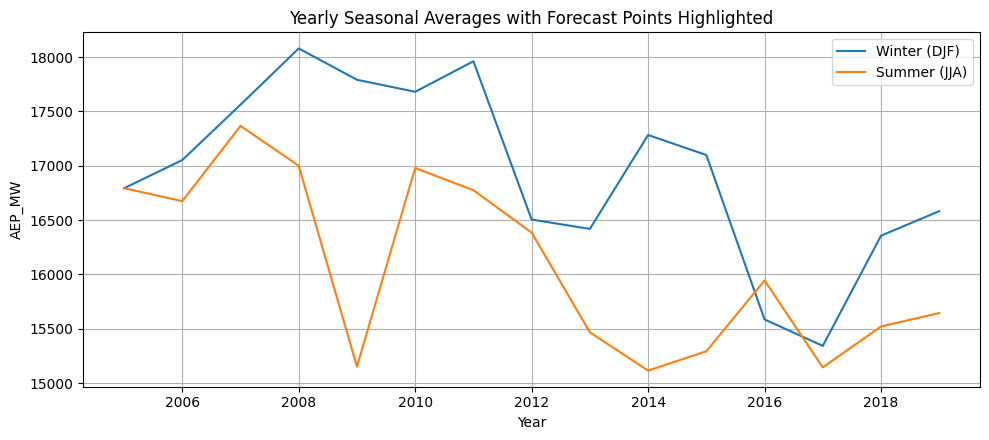

In [10]:
# === Continue from your code above ===
# Build a continuous daily series that includes history + forecast
daily_full = y_daily.copy()
fc_series = fc.copy()
# In case of any overlap, prefer actuals
daily_full = daily_full.combine_first(fc_series)

# Helper: compute per-year DJF (winter) and JJA (summer) means
df_season = daily_full.to_frame(name=val_col)
df_season["year"] = df_season.index.year
df_season["month"] = df_season.index.month

# Winter (DJF): assign a "winter_year" so Dec belongs to next year's winter
def winter_year(dt):
    m = dt.month
    y = dt.year
    return y if m in (1, 2) else (y + 1 if m == 12 else np.nan)

df_season["winter_year"] = df_season.index.to_series().apply(winter_year)
winter_means = (
    df_season[df_season["month"].isin([12, 1, 2])]
    .dropna(subset=["winter_year"])
    .groupby("winter_year")[val_col]
    .mean()
    .rename("Winter_DJF")
)

# Summer (JJA): simple calendar-year grouping
summer_means = (
    df_season[df_season["month"].isin([6, 7, 8])]
    .groupby("year")[val_col]
    .mean()
    .rename("Summer_JJA")
)

# Combine seasonal means into one DataFrame
seasonal_means = pd.concat(
    [
        winter_means.to_frame(),
        summer_means.to_frame(),
    ],
    axis=1
).sort_index()

# Optional: limit to years where we have at least 60 daily observations per season (avoid partial seasons)
# (You can comment this block out if you want to keep partial seasons.)
def count_days_in_season(series, months, assign_year=None):
    tmp = df_season[df_season["month"].isin(months)].copy()
    if assign_year == "winter":
        key = "winter_year"
    else:
        key = "year"
    return tmp.groupby(key)[val_col].count()

winter_counts = count_days_in_season(daily_full, [12,1,2], assign_year="winter")
summer_counts = count_days_in_season(daily_full, [6,7,8], assign_year=None)

valid_winter_years = winter_counts[winter_counts >= 60].index
valid_summer_years = summer_counts[summer_counts >= 60].index

seasonal_means = seasonal_means.loc[
    seasonal_means.index.intersection(valid_winter_years).union(
        seasonal_means.index.intersection(valid_summer_years)
    )
].sort_index()

# Identify which points are forecast (i.e., year >= 2019 for DJF and year >= 2020 for JJA in your setup)
seasonal_means["DJF_is_forecast"] = seasonal_means.index >= 2020   # DJF 2019–2020 labeled as 2020
seasonal_means["JJA_is_forecast"] = seasonal_means.index >= 2020   # JJA 2020

print("Seasonal mean table (last few years):")
print(seasonal_means.tail(6)[["Winter_DJF","Summer_JJA"]])

# --- Line chart: yearly Winter (DJF) and Summer (JJA) averages ---
plt.figure(figsize=(10,4.5))
seasonal_means["Winter_DJF"].plot(marker="o", label="Winter (DJF)")
seasonal_means["Summer_JJA"].plot(marker="o", label="Summer (JJA)")
plt.title("Yearly Seasonal Averages — Winter (DJF) vs Summer (JJA)")
plt.xlabel("Year")
plt.ylabel(val_col)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: emphasize the forecast points with larger markers/annotations ---
plt.figure(figsize=(10,4.5))
# Plot full lines
seasonal_means["Winter_DJF"].plot(label="Winter (DJF)")
seasonal_means["Summer_JJA"].plot(label="Summer (JJA)")

# Highlight forecast points (if present)
djf_fore = seasonal_means[seasonal_means["DJF_is_forecast"]]["Winter_DJF"]
jja_fore = seasonal_means[seasonal_means["JJA_is_forecast"]]["Summer_JJA"]
plt.plot(djf_fore.index, djf_fore.values, "o", markersize=8)
plt.plot(jja_fore.index, jja_fore.values, "o", markersize=8)

plt.title("Yearly Seasonal Averages with Forecast Points Highlighted")
plt.xlabel("Year")
plt.ylabel(val_col)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()